In [1]:
import numpy as np
import pandas as pd
import time
import multiprocessing as mp
import itertools
from astropy.table import hstack, Table
from astropy.io import fits
import astropy.units as u
from pyarrow import parquet
from astropy.coordinates import SkyCoord, Distance
import scipy.interpolate as interp

import os
import sys
import signal
from matplotlib import pyplot as plt

import SPHEREx_ObsSimulator as SPobs
from SPHEREx_Simulator_Tools import SPHEREx_Logger, data_filename
import SPHEREx_InstrumentSimulator as SPinst
import SPHEREx_SkySimulator as SPsky
from spherex_parameters import load_spherex_parameters
from SPHEREx_SkySimulator import QuickCatalog, Catalog_to_Simulate


survey_plan_file = "/Users/gemmahuai/Desktop/CalTech/SPHEREx/Redshift/spherex_survey_plan_R2.fits" # on local machine
# survey_plan_file = "/Users/gemmahuai/Desktop/CalTech/SPHEREx/Redshift/spherex_survey_plan_R2_trunc6month.fits"
SPHEREx_Pointings = SPobs.Pointings(input_file = survey_plan_file,
                                   Gaussian_jitter=0., 
                                   roll_angle='psi2')

# Load instrument and project parameters as a dictionary
spherex_parameters = load_spherex_parameters()

# Scene = SPsky.Scene(SPHEREx_Pointings,
#                          zodi_model=SPsky.zodicalc.ModifiedKelsallModelWithHPFT())
#                    dgl_model =SPsky.DGLCalculator(Logger=Logger), Logger=Logger)
Scene = SPsky.Scene(SPHEREx_Pointings, 
                    zodi_model=SPsky.zodicalc.ModifiedKelsallModelWithHPFT())
                        # zodi_model=SPsky.zodicalc.SkyAveragedZodi(filepath='/Users/gemmahuai/Desktop/CalTech/SPHEREx/SPHEREx_2023/Codes/intensity_mapper_v30.csv'))

SPHEREx_Instrument = SPinst.Instrument(
    instrument_data=spherex_parameters,
    psf=data_filename("psf/simulated_PSF_database_centered_v3_og.fits"),
    psf_downsample_by_array={1: 4, 2: 4, 3: 4, 4: 4, 5: 4, 6: 4},
    psf_trim_by_array={1: 32, 2: 32, 3: 32, 4: 32, 5: 32, 6: 32},
    noise_model=SPinst.white_noise,
    dark_current_model=SPinst.poisson_dark_current,
    lvf_model=SPinst.Tabular_Bandpass()
)

Channels = Table.read(data_filename('Channel_Definition_03022021.fits'))


### Set up some directories
primary_dir = "/Users/gemmahuai/Desktop/CalTech/SPHEREx/Redshift/deep_field/data/blended_QC/"
file_inter = "/Users/gemmahuai/Desktop/CalTech/SPHEREx/Redshift/deep_field/data/blended_QC/"

def find_sed_fits_file_corrected(index, tractorID):
    if index < 60000:
        #print("0 - 60000")
        DIR = "/Users/gemmahuai/Desktop/CalTech/SPHEREx/COSMOS_ALL_HIRES_SEDS_010925/0_60000/"
    elif index < 120000:
        #print("60000 - 120000")
        DIR = "/Users/gemmahuai/Desktop/CalTech/SPHEREx/COSMOS_ALL_HIRES_SEDS_010925/60000_120000/"
    else:
        #print("120000 - ")
        DIR = "/Users/gemmahuai/Desktop/CalTech/SPHEREx/COSMOS_ALL_HIRES_SEDS_010925/120000_166041/"
    
    filename = DIR + f"cosmos2020_hiresSED_FarmerID_{tractorID:07d}_corrected.fits"
    return filename

def calc_source_separation(RA, DEC):
    """
    RA, DEC = numpy arrays of ra, dec
    
    calculates the distance to nearest neighbors for given sources
    
    """
    nearest_distances = []
    coords = SkyCoord(ra=RA * u.deg, dec=DEC * u.deg, frame='icrs')

    # calculate the angular separation to find nearest neighbors
    for ii, coord in enumerate(coords):
        separations = coord.separation(coords)
        separations[ii] = np.inf

        # find the minimum separation, which is the nearest neighbor
        nearest_distance = np.min(separations).to("arcsec").value
        nearest_distances.append(nearest_distance)

    nearest_distances = np.array(nearest_distances)
    
    return nearest_distances

# og 

with fits.open('../../../../SPHEREx_2023/COSMOS2020_FARMER_R1_v2.1_p3_in_Richard_sim_2023Dec4.fits') as fits_data:
    cosmos = Table(fits_data[1].data)

# QC + Tractor deep field run

In [2]:

COSMOS_tab = Table.read("/Users/gemmahuai/Desktop/CalTech/SPHEREx/Redshift/deep_field/data/refcat_cuts/COSMOS2020_SPHEXrefcat_v0.6_166k_matched_Jean8k.csv")
ra_colname = "ra"
dec_colname = "dec"

# idx_refcat = np.loadtxt("/Users/gemmahuai/Desktop/CalTech/SPHEREx/source_selection/cosmos166k_posmatch_boolarray.txt", dtype=bool)
idx_refcat = np.loadtxt("/Users/gemmahuai/Desktop/CalTech/SPHEREx/Redshift/deep_field/data/refcat_cuts/boolean_cut_0.6.txt", 
                        dtype=bool, skiprows=2)
match = COSMOS_tab['match'] == 'True'
xmatch = COSMOS_tab['xmatched_LS_110k']==1


## start testing QC + Tractor
# i = 1526
i = 1346
ra = COSMOS_tab[ra_colname][idx_refcat & match][i]
dec = COSMOS_tab[dec_colname][idx_refcat & match][i]

tractorID = COSMOS_tab['Tractor_ID'][idx_refcat & match][i]
source_ID = np.where(COSMOS_tab["Tractor_ID"] == tractorID)[0][0] # index among 166k

# find input hires sed
sed_path = find_sed_fits_file_corrected(source_ID, tractorID)

print(f"    tractor ID for {i} = ", tractorID, " sed file ", sed_path)


## add nearby photometered sources (< 4 SPHEREx pixels)
size = 4 * 6.2 / 3600 # deg 
idx_close = np.where((COSMOS_tab[ra_colname][idx_refcat & xmatch] <= (ra+size)) &
                     (COSMOS_tab[ra_colname][idx_refcat & xmatch] >= (ra-size)) &
                     (COSMOS_tab[dec_colname][idx_refcat & xmatch] <= (dec+size)) &
                     (COSMOS_tab[dec_colname][idx_refcat & xmatch] >= (dec-size)))[0]
print("   Number of nearby photometered sources  = ", len(idx_close))

## calculate distance to the nearest neighbor
sep = calc_source_separation(COSMOS_tab['ra'][idx_refcat&xmatch][idx_close], COSMOS_tab['dec'][idx_refcat&xmatch][idx_close])
print('smallest separation = ', np.nanmin(sep), ' arcsec')


    tractor ID for 1346 =  252366  sed file  /Users/gemmahuai/Desktop/CalTech/SPHEREx/COSMOS_ALL_HIRES_SEDS_010925/0_60000/cosmos2020_hiresSED_FarmerID_0252366_corrected.fits
   Number of nearby photometered sources  =  8
smallest separation =  7.852300385807217  arcsec


In [59]:
## plot, check refcat selection

# def get_mag_from_flux(flux_Jy):
#     mag = -2.5 * np.log10(flux_Jy / 3631)
#     return mag

# mag_w1 = get_mag_from_flux(COSMOS_tab['LS_W1'] / 1e6)
# mag_z  = get_mag_from_flux(COSMOS_tab['LS_z']  / 1e6)

# fig = plt.figure(figsize=(6,5))
# plt.scatter(mag_z, mag_z - mag_w1, s=1, alpha=0.1)
# plt.scatter(mag_z[match], mag_z[match] - mag_w1[match], s=1, color='black')
# plt.scatter(mag_z[match & idx_refcat], mag_z[match & idx_refcat] - mag_w1[match & idx_refcat], s=1, color='red')
# plt.scatter(mag_z[idx_refcat&xmatch][idx_close], mag_z[idx_refcat&xmatch][idx_close] - mag_w1[idx_refcat&xmatch][idx_close], s=10, color='green')
# plt.show()


In [180]:

# initialize QuickCatalog, only forced photometry, no Tractor
QC = QuickCatalog(SPHEREx_Pointings, SPHEREx_Instrument, Scene, spectral_channel_table=Channels, \
                  Use_Tractor=False, \
                  subpixel_offset_x=0, subpixel_offset_y=0)

Sources_to_Simulate = Catalog_to_Simulate()

Sources_to_Simulate.load_single(name='COSMOS_{}'.format(tractorID),
                                ra=ra*u.deg, 
                                dec=dec*u.deg,
                                inputpath=sed_path, 
                                no_phot='yes')


## add into QC to photometer
# ii = 0
# for idx in idx_close:
#     print(ii)

#     if COSMOS_tab['Tractor_ID'][idx_refcat&cosmology][idx] == tractorID:
#         # skip the primary central source itself
#         continue
        
# #     if ii > 1:
# #         print(ii, "break")
# #         break

#     ra_this = COSMOS_tab[ra_colname][idx_refcat&cosmology][idx]
#     dec_this = COSMOS_tab[dec_colname][idx_refcat&cosmology][idx]
#     tractorID_this = COSMOS_tab['Tractor_ID'][idx_refcat&cosmology][idx]
#     source_ID_this = np.where(COSMOS_tab["Tractor_ID"] == tractorID_this)[0][0] # index among 166k

#     sed_this = find_sed_fits_file_corrected(source_ID_this, tractorID_this)
#     print("   tractor ID ", tractorID_this, "sed file ", sed_this)
#     Sources_to_Simulate.load_single(name='COSMOS_{}'.format(tractorID_this),
#                                     ra=ra_this*u.deg, 
#                                     dec=dec_this*u.deg,
#                                     inputpath=sed_this)
    
#     ii += 1

print("photometry with QC...")
# photometry
SPHEREx_Catalog_2yr, Truth_Catalog_2yr = QC(Sources_to_Simulate) 
print("Done QC")

id_primary = SPHEREx_Catalog_2yr['SOURCE_ID'] == f'COSMOS_{tractorID}'

### calculate secondary photometry
SPsky.save_level3_secondary(SPHEREx_Catalog_2yr[id_primary], 
                            Channels, 
                            SPHEREx_Instrument, 
                            '../data/secondary_phot_id{}_2yr.parq'.format(tractorID), 
                            pointing_table=SPHEREx_Pointings.pointing_table, 
                            fluxerr_from_weights=True)


photometry with QC...
Done QC


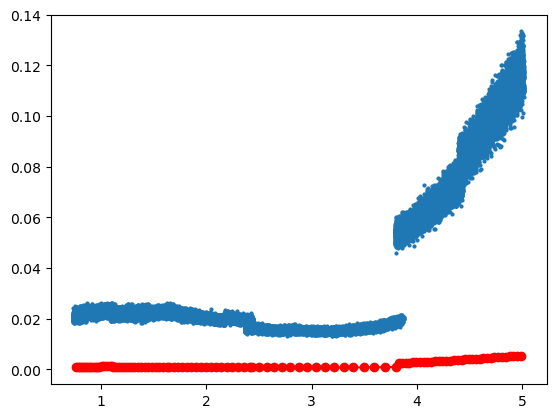

In [181]:
dd_2yr = Table.read('../data/secondary_phot_id{}_2yr.parq'.format(tractorID))

plt.plot(SPHEREx_Catalog_2yr['WAVELENGTH'][id_primary], SPHEREx_Catalog_2yr['FLUX_ERR'][id_primary], 'o',ms=2)
# plt.plot(SPHEREx_Catalog['WAVELENGTH'][id_primary], SPHEREx_Catalog['FLUX_ERR'][id_primary]/20, 'o', ms=2, color='green')
plt.plot(dd_2yr['lambda'][0], dd_2yr['flux_err_deepfield'][0]/1000, color='red', marker='o')
# plt.xlim(3.04,3.13)


(0.0, 0.134)

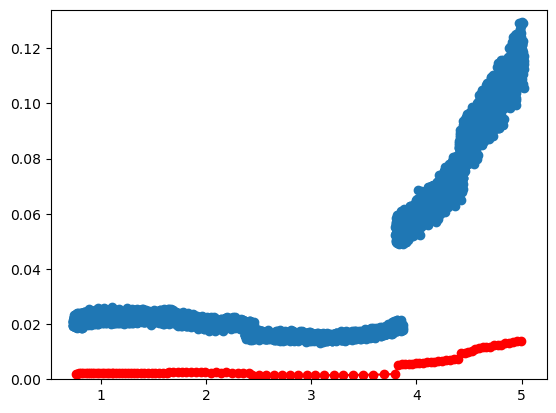

In [166]:

dd_6mo = Table.read('../data/secondary_phot_id{}_6mo.parq'.format(tractorID))

plt.plot(SPHEREx_Catalog_6mo['WAVELENGTH'][id_primary], SPHEREx_Catalog_6mo['FLUX_ERR'][id_primary], 'o')
# plt.plot(SPHEREx_Catalog_3mo['WAVELENGTH'][id_primary], SPHEREx_Catalog_3mo['FLUX_ERR'][id_primary]/2, 'o', ms=2, color='green')
plt.plot(dd_6mo['lambda'][0], dd_6mo['flux_err_deepfield'][0]/1000, color='red', marker='o')
# plt.xlim(3,3.5)
plt.ylim(0, 0.134)


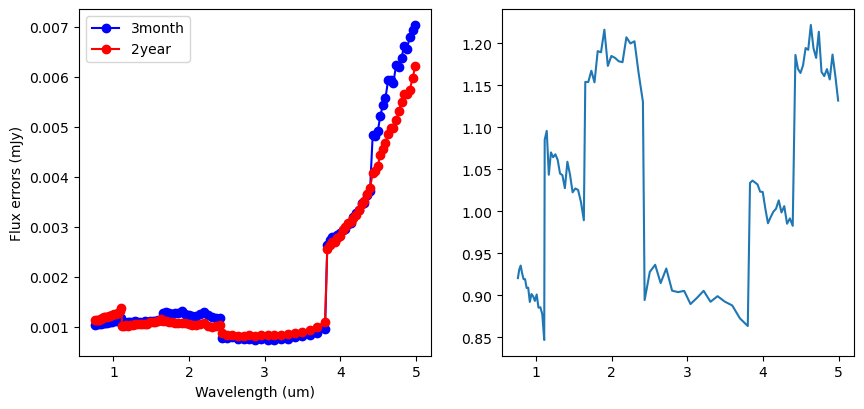

In [153]:
plt.figure(figsize=(10,4.5))

dd_2yr = Table.read('../data/secondary_phot_id{}_2yr.parq'.format(tractorID))
dd_6mo = Table.read('../data/secondary_phot_id{}_6mo.parq'.format(tractorID))

plt.subplot(1,2,1)
f_err_3mo = dd_6mo['flux_err_deepfield'][0]/1000 / 2
f_err_2yr = dd_2yr['flux_err_deepfield'][0]/1000
plt.plot(dd_3mo['lambda'][0], f_err_3mo, color='blue', marker='o', label='3month')
plt.plot(dd_2yr['lambda'][0], f_err_2yr, color='red', marker='o', label='2year')
plt.legend()
plt.xlabel("Wavelength (um)")
plt.ylabel("Flux errors (mJy)")

# see the difference
plt.subplot(1,2,2)
plt.plot(dd_3mo['lambda'][0], 
         f_err_3mo / f_err_2yr)

### Well, this isn't quite right, 


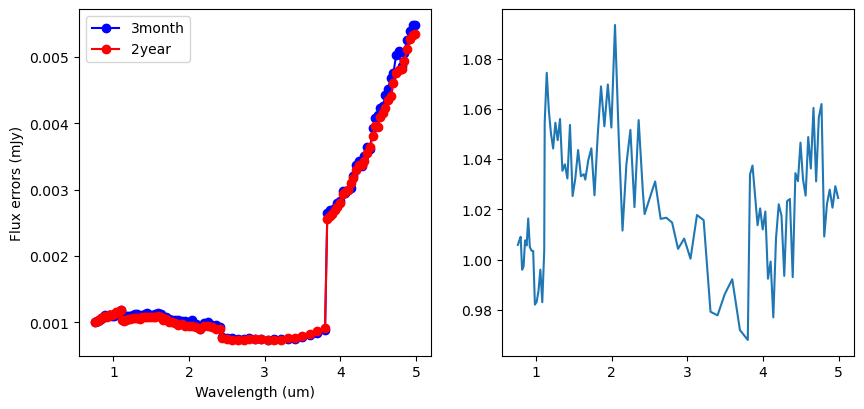

In [182]:
plt.figure(figsize=(10,4.5))

dd_2yr = Table.read('../data/secondary_phot_id{}_2yr.parq'.format(tractorID))
dd_6mo = Table.read('../data/secondary_phot_id{}_6mo.parq'.format(tractorID))

plt.subplot(1,2,1)
f_err_3mo = dd_6mo['flux_err_deepfield'][0]/1000 / 2
f_err_2yr = dd_2yr['flux_err_deepfield'][0]/1000
plt.plot(dd_3mo['lambda'][0], f_err_3mo, color='blue', marker='o', label='3month')
plt.plot(dd_2yr['lambda'][0], f_err_2yr, color='red', marker='o', label='2year')
plt.legend()
plt.xlabel("Wavelength (um)")
plt.ylabel("Flux errors (mJy)")

# see the difference
plt.subplot(1,2,2)
plt.plot(dd_3mo['lambda'][0], 
         f_err_3mo / f_err_2yr)

### Well, this isn't quite right, 


## Sample ra, dec, check scaling

In [344]:
def calc_scaling_given_radec(ra, dec, survey=None):
    
    if survey in ['1month', '2month', '3month', '6month', '1week']:
        survey_plan_file = "/Users/gemmahuai/Desktop/CalTech/SPHEREx/Redshift/spherex_survey_plan_R2_trunc" + survey + ".fits"
    else:
        survey='2yr'
        # full 2 year survey plan
        survey_plan_file = "/Users/gemmahuai/Desktop/CalTech/SPHEREx/Redshift/spherex_survey_plan_R2.fits"
    
    SPHEREx_Pointings = SPobs.Pointings(input_file = survey_plan_file,
                                        Gaussian_jitter=0., 
                                        roll_angle='psi2')
    # Load instrument and project parameters as a dictionary
    spherex_parameters = load_spherex_parameters()
    Scene = SPsky.Scene(SPHEREx_Pointings, 
                        zodi_model=SPsky.zodicalc.ModifiedKelsallModelWithHPFT())
    
    
    # find nearest source to photometer
    id = np.where(np.isclose(COSMOS_tab['ra_deep'][idx_refcat], ra, atol=1e-2) & 
                  np.isclose(COSMOS_tab['dec_deep'][idx_refcat], dec, atol=1e-2))[0]
    id = id[0] # pick the first one, close enough
    
    ra = COSMOS_tab[ra_colname][idx_refcat][id]
    # print(ra)
    dec = COSMOS_tab[dec_colname][idx_refcat][id]
    # print(dec)
    # print(f'../data/secondary_phot_ra{ra:.4f}_dec{dec:.4f}_'+survey+'.parq')

    tractorID = COSMOS_tab['Tractor_ID'][idx_refcat][id]
    source_ID = np.where(COSMOS_tab["Tractor_ID"] == tractorID)[0][0] # index among 166k

    # find input hires sed
    sed_path = find_sed_fits_file_corrected(source_ID, tractorID)
    # print(f"    tractor ID for {i} = ", tractorID, " sed file ", sed_path)
    
    # initialize QuickCatalog, only forced photometry, no Tractor
    QC = QuickCatalog(SPHEREx_Pointings, SPHEREx_Instrument, Scene, spectral_channel_table=Channels, \
                      Use_Tractor=False, \
                      subpixel_offset_x=0, subpixel_offset_y=0)

    Sources_to_Simulate = Catalog_to_Simulate()

    Sources_to_Simulate.load_single(name='COSMOS_{}'.format(tractorID),
                                    ra=ra*u.deg, 
                                    dec=dec*u.deg,
                                    inputpath=sed_path, 
                                    no_phot='yes')

    SPHEREx_Catalog, Truth_Catalog = QC(Sources_to_Simulate, nmc=50) 
    # print("    Done QC")

    id_primary = SPHEREx_Catalog['SOURCE_ID'] == f'COSMOS_{tractorID}'

    ### calculate secondary photometry
    SPsky.save_level3_secondary(SPHEREx_Catalog[id_primary], 
                                Channels, 
                                SPHEREx_Instrument, 
                                f'../data/secondary_phot_ra{ra:.4f}_dec{dec:.4f}_'+survey+'.parq', 
                                pointing_table=SPHEREx_Pointings.pointing_table, 
                                fluxerr_from_weights=True)
    
    # read the secondary photometry
    sec = Table.read(f'../data/secondary_phot_ra{ra:.4f}_dec{dec:.4f}_'+survey+'.parq')
    return sec




Text(0, 0.5, 'DEC')

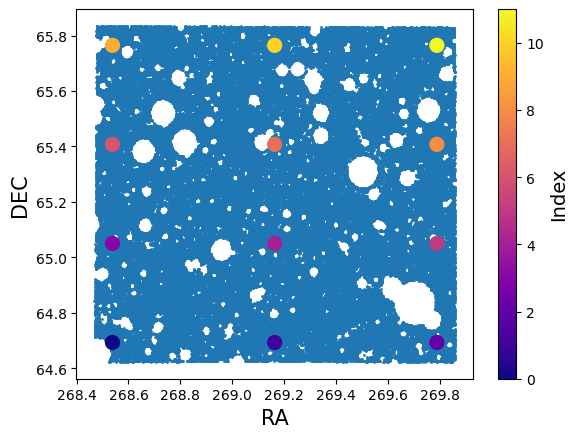

In [347]:
## sample points in the deep field COSMOS field... check scaling factor

plt.scatter(COSMOS_tab['ra_deep'], COSMOS_tab['dec_deep'], s=1)

## sample the area
ra_l = COSMOS_tab['ra_deep'].min()+0.07
ra_h = COSMOS_tab['ra_deep'].max()-0.07
dec_l = COSMOS_tab['dec_deep'].min()+0.07
dec_h = COSMOS_tab['dec_deep'].max()-0.07

step_ra = (ra_h - ra_l) / 2
step_dec = (dec_h - dec_l) / 3

# initialize
i = 0
dec = dec_l

RAs = []
DECs = []
while dec < (dec_h):
    
    dec = dec_l + step_dec * i
    
    j = 0
    ra = ra_l
    while ra < (ra_h):
        ra = ra_l + step_ra * j
        RAs.append(ra)
        
        j += 1
        DECs.append(dec)
    
    i += 1
    
# plot the sampled points
plt.scatter(RAs, DECs, c=np.arange(len(RAs)), s=100, cmap='plasma')
cbar = plt.colorbar()
cbar.set_label("Index", fontsize=14)
plt.xlabel("RA", fontsize=15)
plt.ylabel("DEC", fontsize=15)

0 268.5384412303314 64.6926352080033


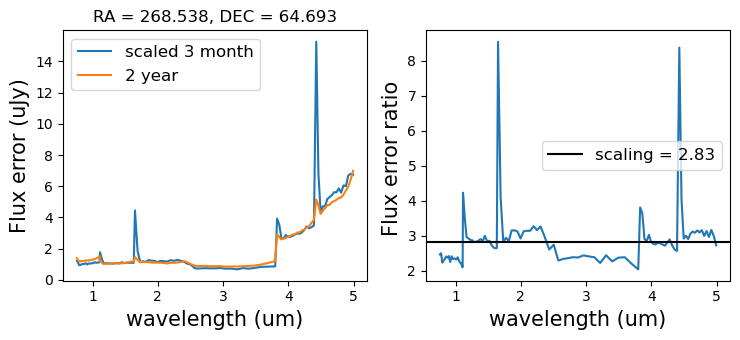

1 269.16357421875 64.6926352080033


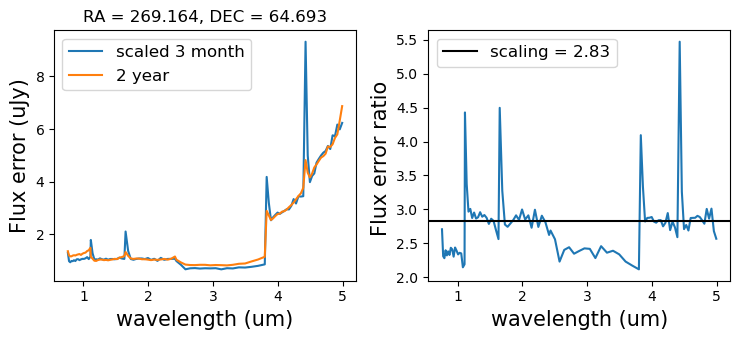

2 269.78870720716856 64.6926352080033


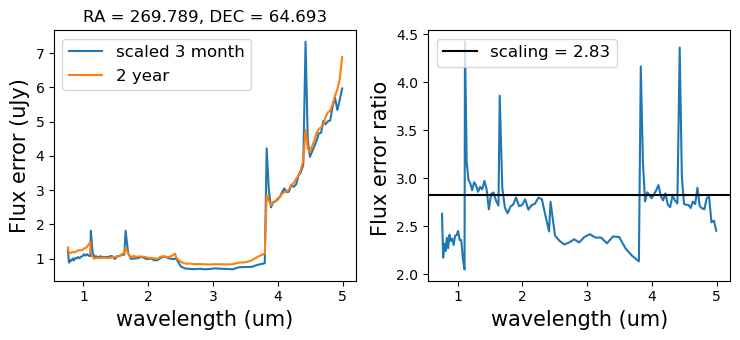

3 268.5384412303314 65.22880554199219


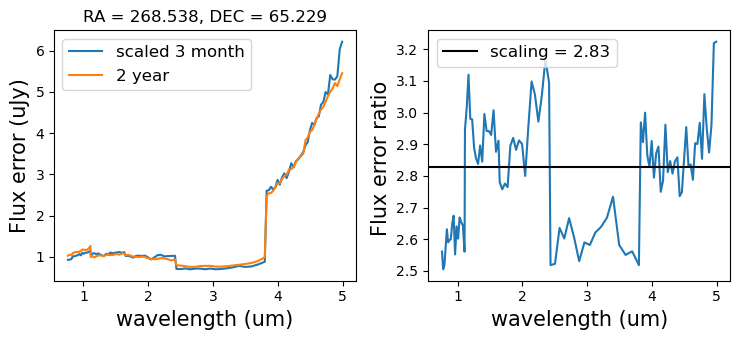

4 269.16357421875 65.22880554199219


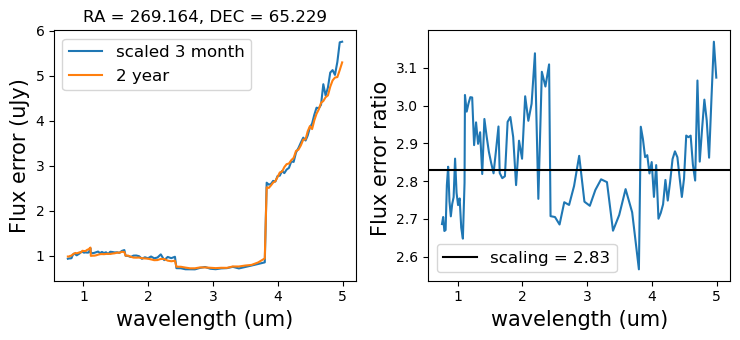

5 269.78870720716856 65.22880554199219


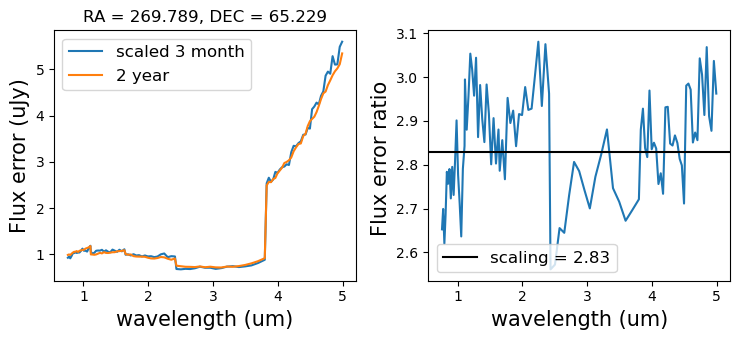

6 268.5384412303314 65.76497587598108


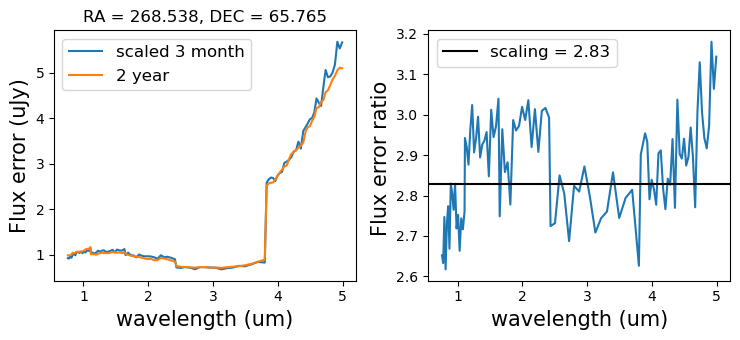

7 269.16357421875 65.76497587598108


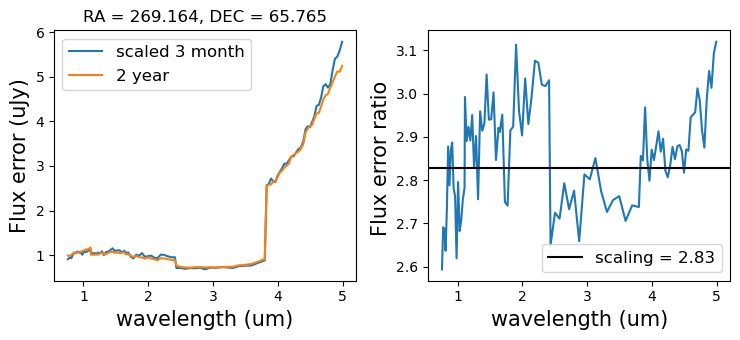

8 269.78870720716856 65.76497587598108


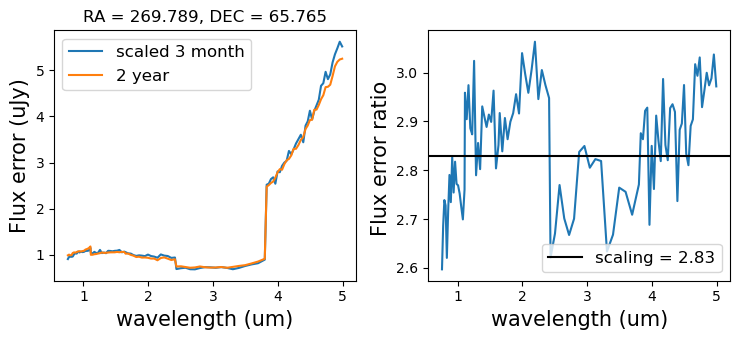

In [342]:

scale = 24 / 3 # 24 months / 3 months

wls = []
fluxerrs_2yr = []
fluxerrs_3mo = []

for i, (ra, dec) in enumerate(zip(RAs, DECs)):
    print(i, ra, dec)

    # 2-year survey, save secondary flux_err_deepfield
    sec_2yr = calc_scaling_given_radec(ra=ra, dec=dec)
    wls.append(sec_2yr['lambda'][0])
    fluxerrs_2yr.append(sec_2yr['flux_err_deepfield'][0])

    # truncated survey
    sec_3mo = calc_scaling_given_radec(ra=ra, dec=dec, survey='3month')
    fluxerrs_3mo.append(sec_3mo['flux_err_deepfield'][0])

    ## plot 
    fig = plt.figure(figsize=(7.5,3.5))
    plt.subplot(1,2,1)
    plt.plot(sec_3mo['lambda'][0], sec_3mo['flux_err_deepfield'][0] / np.sqrt(scale), label='scaled 3 month')
    plt.plot(sec_2yr['lambda'][0], sec_2yr['flux_err_deepfield'][0], label = '2 year')
    plt.legend(fontsize=12)
    plt.xlabel("wavelength (um)", fontsize=15)
    plt.ylabel("Flux error (uJy)", fontsize=15)
    plt.title(f"RA = {ra:.3f}, DEC = {dec:.3f}")

    plt.subplot(1,2,2)
    plt.plot(sec_3mo['lambda'][0], sec_3mo['flux_err_deepfield'][0] / sec_2yr['flux_err_deepfield'][0])
    plt.axhline(np.sqrt(scale), color='black', label=f'scaling = {np.sqrt(scale):.2f}')
    plt.legend(fontsize=12)
    plt.xlabel("wavelength (um)", fontsize=15)
    plt.ylabel("Flux error ratio ", fontsize=15)
    fig.tight_layout()
    plt.show()
    



0 268.5384412303314 64.6926352080033


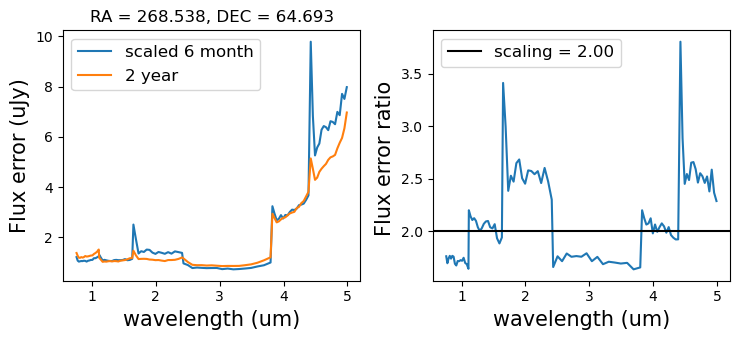

1 269.16357421875 64.6926352080033


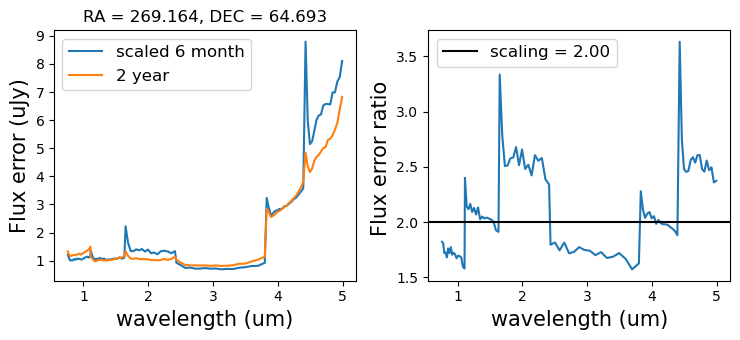

2 269.78870720716856 64.6926352080033


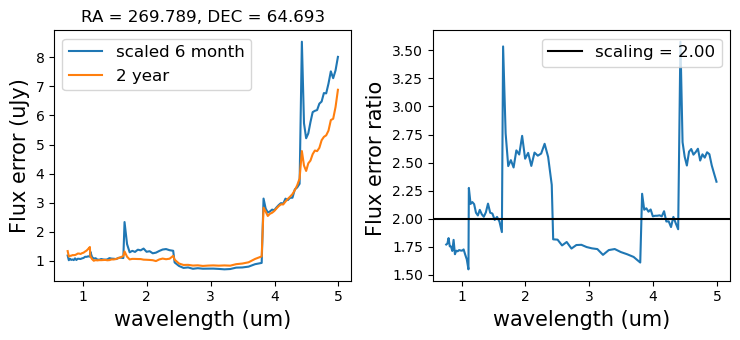

3 268.5384412303314 65.05008209732922


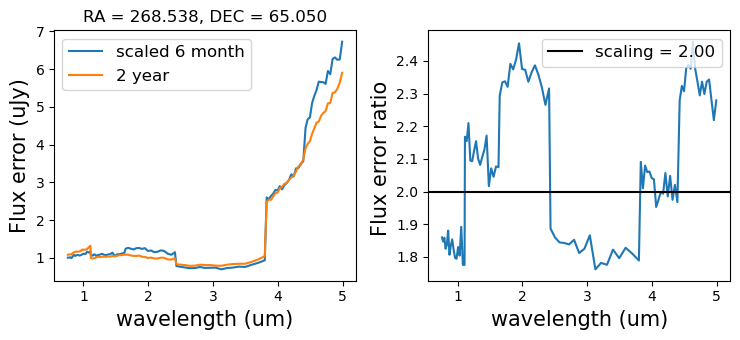

4 269.16357421875 65.05008209732922


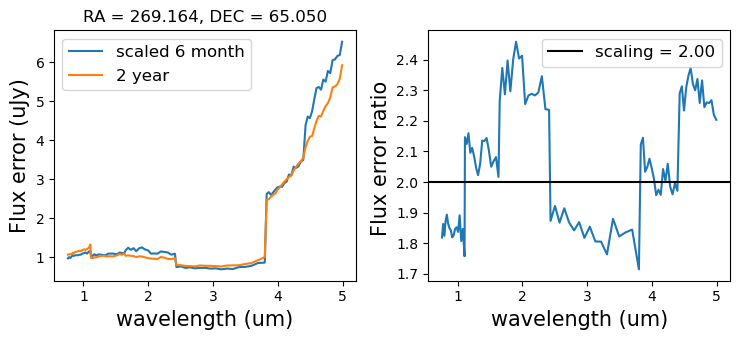

5 269.78870720716856 65.05008209732922


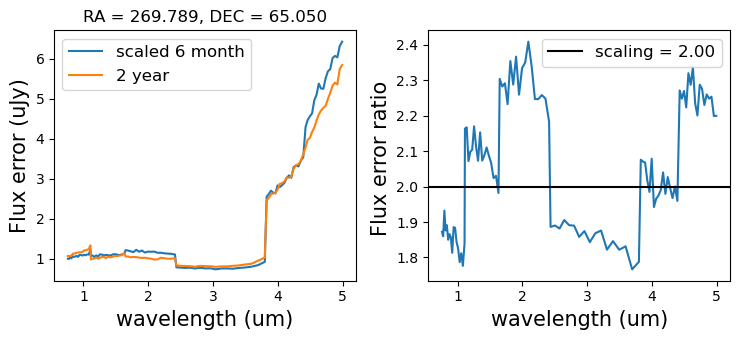

6 268.5384412303314 65.40752898665515


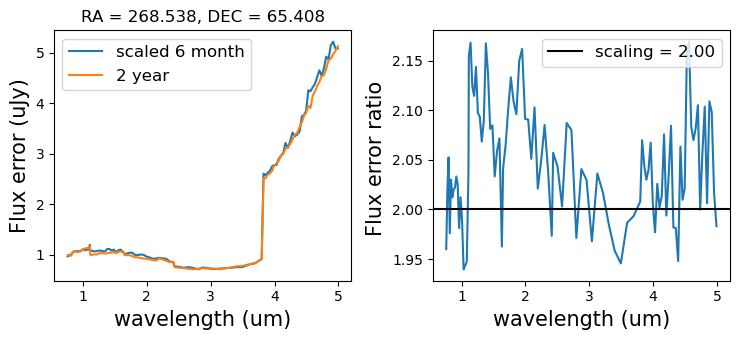

7 269.16357421875 65.40752898665515


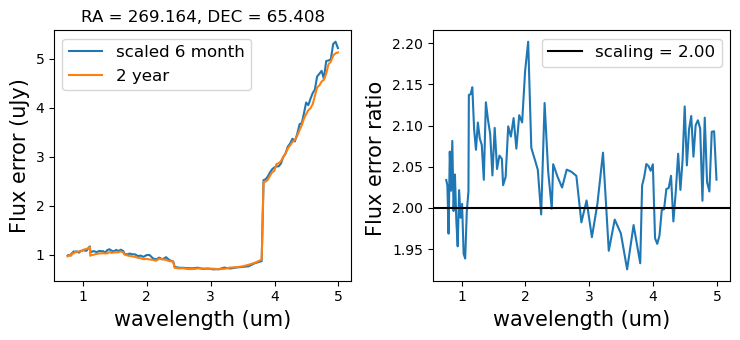

8 269.78870720716856 65.40752898665515


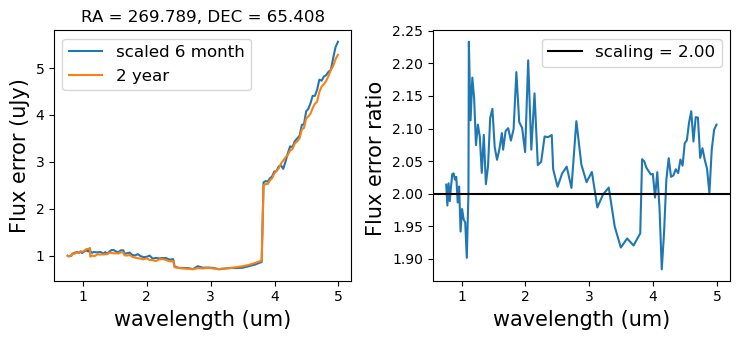

9 268.5384412303314 65.76497587598108


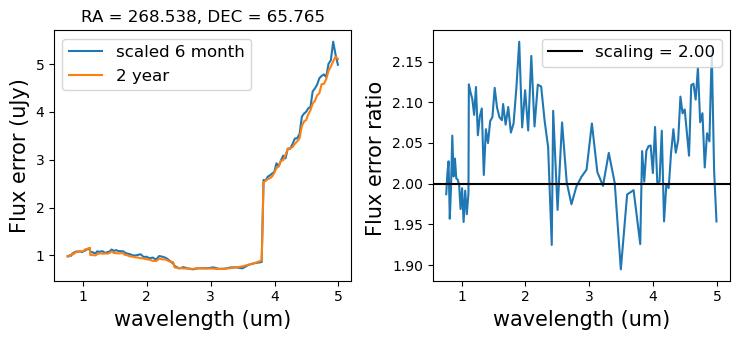

10 269.16357421875 65.76497587598108


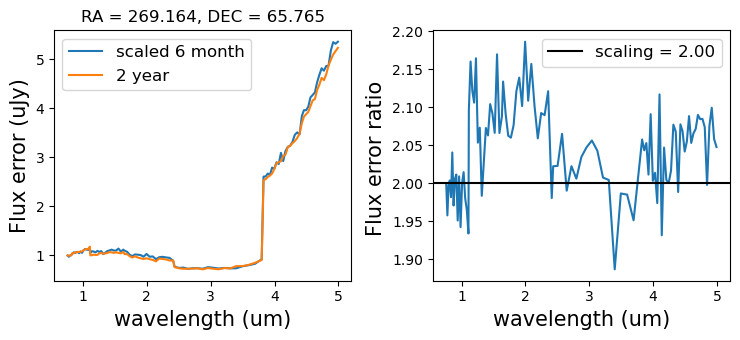

11 269.78870720716856 65.76497587598108


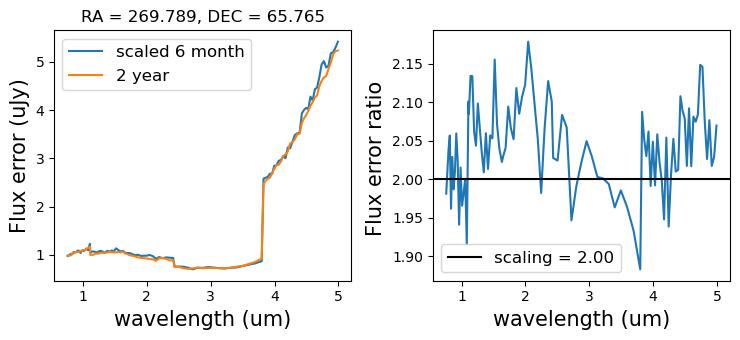

In [346]:

scale = 24 / 6 # 24 months / 6 months

wls = []
fluxerrs_2yr = []
fluxerrs_6mo = []

for i, (ra, dec) in enumerate(zip(RAs, DECs)):
    print(i, ra, dec)

    # 2-year survey, save secondary flux_err_deepfield
    sec_2yr = calc_scaling_given_radec(ra=ra, dec=dec)
    wls.append(sec_2yr['lambda'][0])
    fluxerrs_2yr.append(sec_2yr['flux_err_deepfield'][0])

    # truncated survey
    sec_6mo = calc_scaling_given_radec(ra=ra, dec=dec, survey='6month')
    fluxerrs_6mo.append(sec_6mo['flux_err_deepfield'][0])

    ## plot 
    fig = plt.figure(figsize=(7.5,3.5))
    plt.subplot(1,2,1)
    plt.plot(sec_6mo['lambda'][0], sec_6mo['flux_err_deepfield'][0] / np.sqrt(scale), label='scaled 6 month')
    plt.plot(sec_2yr['lambda'][0], sec_2yr['flux_err_deepfield'][0], label = '2 year')
    plt.legend(fontsize=12)
    plt.xlabel("wavelength (um)", fontsize=15)
    plt.ylabel("Flux error (uJy)", fontsize=15)
    plt.title(f"RA = {ra:.3f}, DEC = {dec:.3f}")

    plt.subplot(1,2,2)
    plt.plot(sec_6mo['lambda'][0], sec_6mo['flux_err_deepfield'][0] / sec_2yr['flux_err_deepfield'][0])
    plt.axhline(np.sqrt(scale), color='black', label=f'scaling = {np.sqrt(scale):.2f}')
    plt.legend(fontsize=12)
    plt.xlabel("wavelength (um)", fontsize=15)
    plt.ylabel("Flux error ratio ", fontsize=15)
    fig.tight_layout()
    plt.show()
    



In [354]:
### so 6 months, above DEC ~ 65.05

# check how many sources from Jean's 8k are above dec 65.05
print("N srcs remaining > dec 65.05 = ", len(COSMOS_tab[match & (COSMOS_tab['dec_deep']>65.06)]))


print("N srcs remaining > dec 65.05, pass the cut = ", len(COSMOS_tab[idx_refcat & match & (COSMOS_tab['dec_deep']>65.06)]))


N srcs remaining > dec 65.05 =  5034
N srcs remaining > dec 65.05, pass the cut =  3624


## Truncate survey plan R3

In [359]:
survey_file = "/Users/gemmahuai/Desktop/CalTech/SPHEREx/Redshift/deep_field/data/spherex_survey_plan_R3_trunc3month.fits"
# survey_file = "/Users/gemmahuai/Desktop/CalTech/SPHEREx/Redshift/deep_field/data/spherex_survey_plan_R3_trunc6month.fits"


# ## truncate the fits file 
# with fits.open(survey_file, mode='update') as hdul:
#     print(len(hdul))
#     dd = hdul[1].data
    
#     # the first 7/30/60/180 days of observation
#     time_cut = dd['time'] < (dd['time'].min()+95)
#     dd_truncated = dd[time_cut]
    
#     hdul[1].data = dd_truncated
#     hdul.flush()
    

2


## Rerun the scaling calculation with R3

In [364]:
def calc_scaling_given_radec(ra, dec, survey=None):
    
    if survey in ['3month', '6month']:
        survey_plan_file = "/Users/gemmahuai/Desktop/CalTech/SPHEREx/Redshift/deep_field/data/survey_plan/spherex_survey_plan_R3_trunc" + survey + ".fits"
    else:
        survey='2yr'
        # full 2 year survey plan
        survey_plan_file = "/Users/gemmahuai/Desktop/CalTech/SPHEREx/Redshift/deep_field/data/survey_plan/spherex_survey_plan_R3.fits"
    
    SPHEREx_Pointings = SPobs.Pointings(input_file = survey_plan_file,
                                        Gaussian_jitter=0., 
                                        roll_angle='psi2')
    # Load instrument and project parameters as a dictionary
    spherex_parameters = load_spherex_parameters()
    Scene = SPsky.Scene(SPHEREx_Pointings, 
                        zodi_model=SPsky.zodicalc.ModifiedKelsallModelWithHPFT())
    
    
    # find nearest source to photometer
    id = np.where(np.isclose(COSMOS_tab['ra_deep'][idx_refcat], ra, atol=1e-2) & 
                  np.isclose(COSMOS_tab['dec_deep'][idx_refcat], dec, atol=1e-2))[0]
    id = id[0] # pick the first one, close enough
    
    ra = COSMOS_tab[ra_colname][idx_refcat][id]
    # print(ra)
    dec = COSMOS_tab[dec_colname][idx_refcat][id]
    # print(dec)
    # print(f'../data/secondary_phot_ra{ra:.4f}_dec{dec:.4f}_'+survey+'.parq')

    tractorID = COSMOS_tab['Tractor_ID'][idx_refcat][id]
    source_ID = np.where(COSMOS_tab["Tractor_ID"] == tractorID)[0][0] # index among 166k

    # find input hires sed
    sed_path = find_sed_fits_file_corrected(source_ID, tractorID)
    # print(f"    tractor ID for {i} = ", tractorID, " sed file ", sed_path)
    
    # initialize QuickCatalog, only forced photometry, no Tractor
    QC = QuickCatalog(SPHEREx_Pointings, SPHEREx_Instrument, Scene, spectral_channel_table=Channels, \
                      Use_Tractor=False, \
                      subpixel_offset_x=0, subpixel_offset_y=0)

    Sources_to_Simulate = Catalog_to_Simulate()

    Sources_to_Simulate.load_single(name='COSMOS_{}'.format(tractorID),
                                    ra=ra*u.deg, 
                                    dec=dec*u.deg,
                                    inputpath=sed_path, 
                                    no_phot='yes')

    SPHEREx_Catalog, Truth_Catalog = QC(Sources_to_Simulate, nmc=50) 
    # print("    Done QC")

    id_primary = SPHEREx_Catalog['SOURCE_ID'] == f'COSMOS_{tractorID}'

    ### calculate secondary photometry
    SPsky.save_level3_secondary(SPHEREx_Catalog[id_primary], 
                                Channels, 
                                SPHEREx_Instrument, 
                                f'../data/secondary_phot_ra{ra:.4f}_dec{dec:.4f}_'+survey+'.parq', 
                                pointing_table=SPHEREx_Pointings.pointing_table, 
                                fluxerr_from_weights=True)
    
    # read the secondary photometry
    sec = Table.read(f'../data/secondary_phot_ra{ra:.4f}_dec{dec:.4f}_'+survey+'.parq')
    return sec



0 268.5384412303314 64.6926352080033


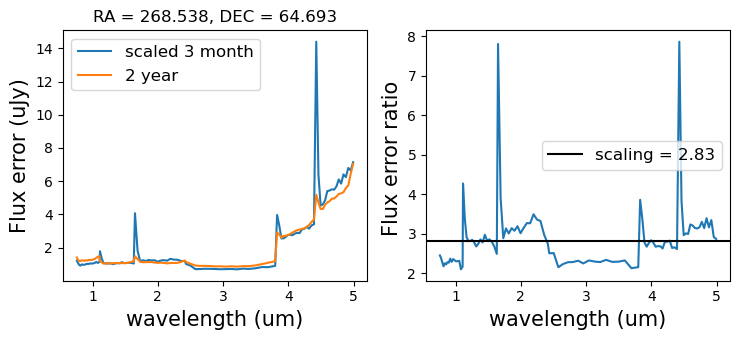

1 269.16357421875 64.6926352080033


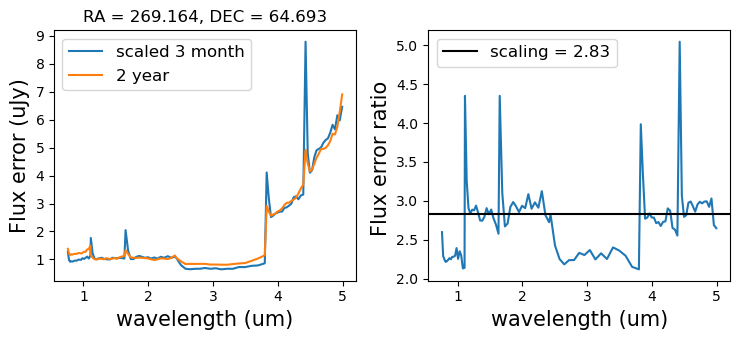

2 269.78870720716856 64.6926352080033


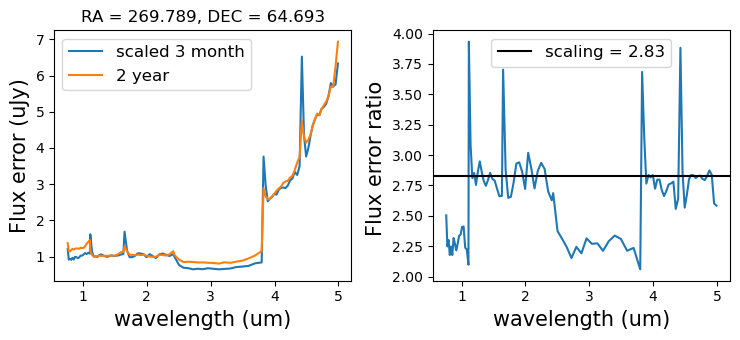

3 268.5384412303314 65.05008209732922


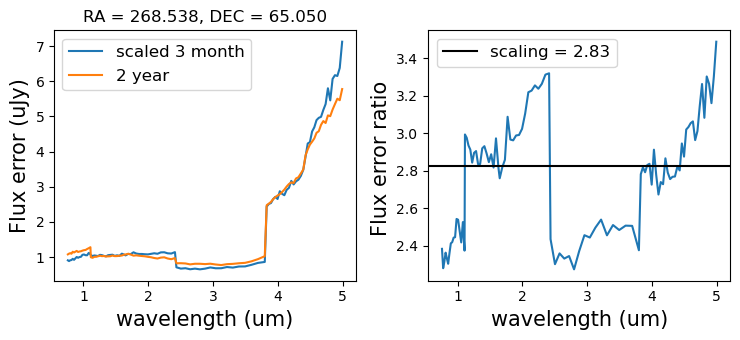

4 269.16357421875 65.05008209732922


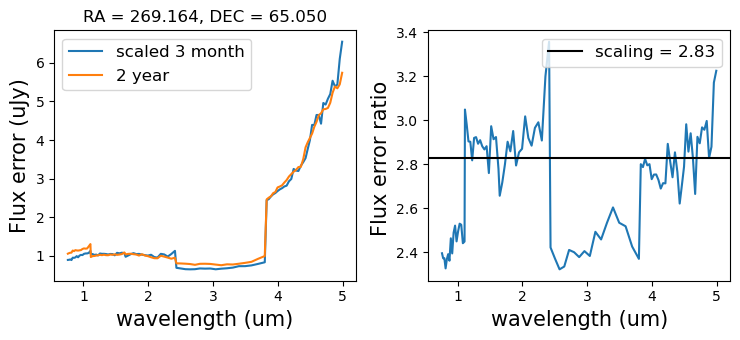

5 269.78870720716856 65.05008209732922


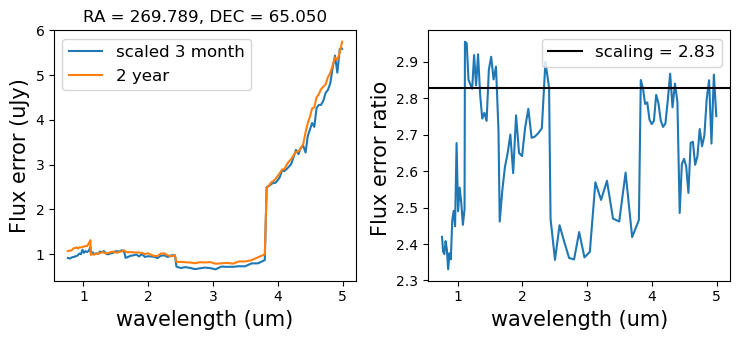

6 268.5384412303314 65.40752898665515


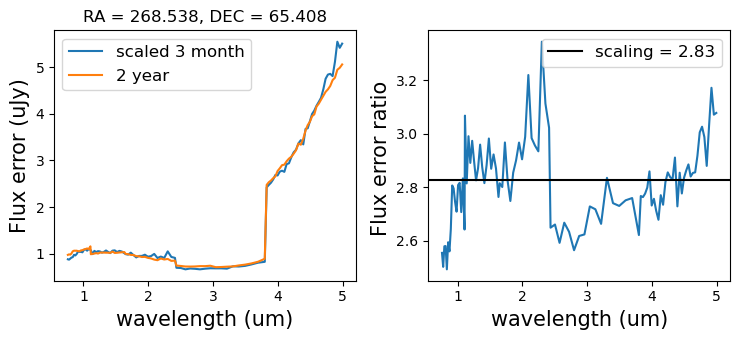

7 269.16357421875 65.40752898665515


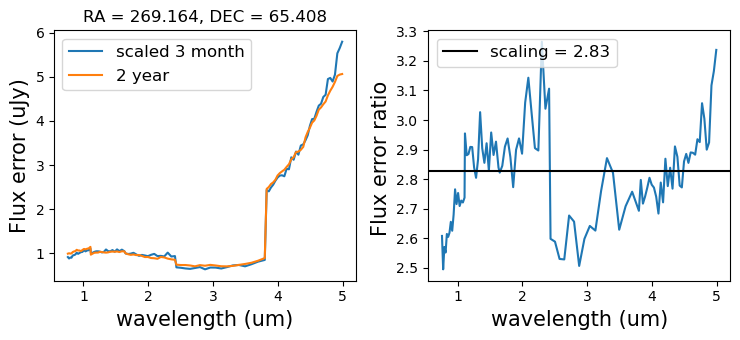

8 269.78870720716856 65.40752898665515


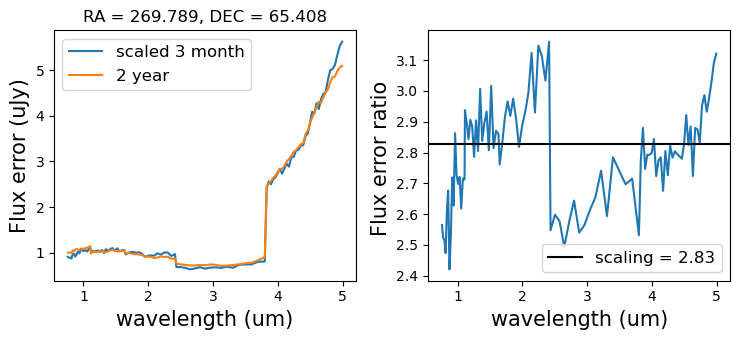

9 268.5384412303314 65.76497587598108


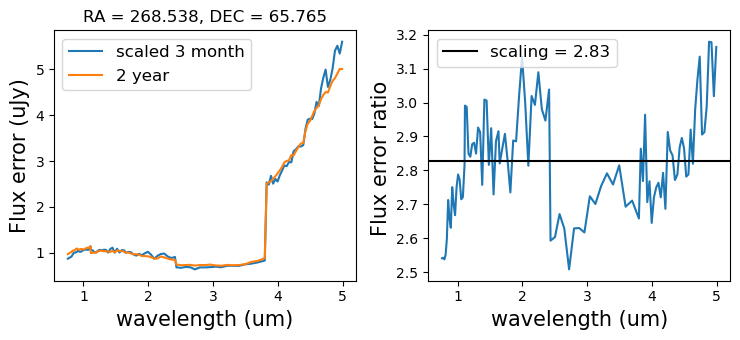

10 269.16357421875 65.76497587598108


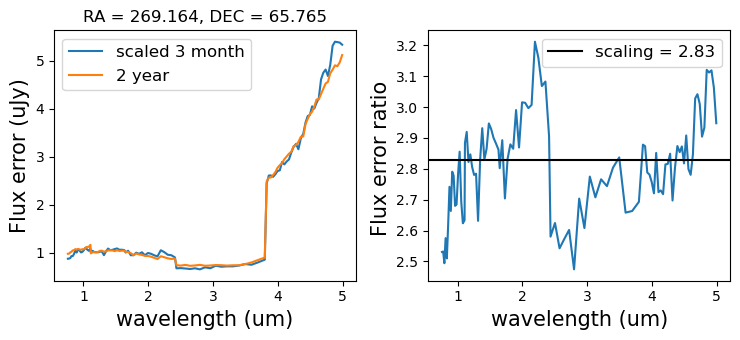

11 269.78870720716856 65.76497587598108


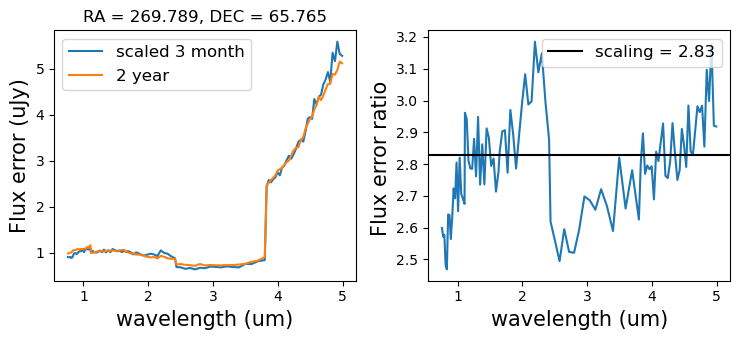

In [365]:

scale = 24 / 3 # 24 months / 3 months

wls = []
fluxerrs_2yr = []
fluxerrs_3mo = []

for i, (ra, dec) in enumerate(zip(RAs, DECs)):
    print(i, ra, dec)

    # 2-year survey, save secondary flux_err_deepfield
    sec_2yr = calc_scaling_given_radec(ra=ra, dec=dec)
    wls.append(sec_2yr['lambda'][0])
    fluxerrs_2yr.append(sec_2yr['flux_err_deepfield'][0])

    # truncated survey
    sec_3mo = calc_scaling_given_radec(ra=ra, dec=dec, survey='3month')
    fluxerrs_3mo.append(sec_3mo['flux_err_deepfield'][0])

    ## plot 
    fig = plt.figure(figsize=(7.5,3.5))
    plt.subplot(1,2,1)
    plt.plot(sec_3mo['lambda'][0], sec_3mo['flux_err_deepfield'][0] / np.sqrt(scale), label='scaled 3 month')
    plt.plot(sec_2yr['lambda'][0], sec_2yr['flux_err_deepfield'][0], label = '2 year')
    plt.legend(fontsize=12)
    plt.xlabel("wavelength (um)", fontsize=15)
    plt.ylabel("Flux error (uJy)", fontsize=15)
    plt.title(f"RA = {ra:.3f}, DEC = {dec:.3f}")

    plt.subplot(1,2,2)
    plt.plot(sec_3mo['lambda'][0], sec_3mo['flux_err_deepfield'][0] / sec_2yr['flux_err_deepfield'][0])
    plt.axhline(np.sqrt(scale), color='black', label=f'scaling = {np.sqrt(scale):.2f}')
    plt.legend(fontsize=12)
    plt.xlabel("wavelength (um)", fontsize=15)
    plt.ylabel("Flux error ratio ", fontsize=15)
    fig.tight_layout()
    plt.show()
    

